# Questions
1. Why is the context length set to 2048? Look up hugging face documentation
2. What is the number you put in for 'xquery = 20100000' what is it related to?

In [27]:
## Install necessary libraries
# !pip install datasets
# !pip install wandb
# !pip install note_seq
# !pip install transformers[torch]
#!pip install accelerate -U

In [2]:
# Import necessary libraries and modules
import os
from argparse import Namespace

import note_seq
import numpy as np
import wandb
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoConfig, GPT2LMHeadModel, DataCollatorForLanguageModeling, set_seed, Trainer, TrainingArguments

import matplotlib.pyplot as plt


C:\Users\naomi\anaconda3\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
# Set the Protocol Buffers Python implementation to "python"
# This line is used to resolve compatibility issues related to Protocol Buffers (protobuf)
# It explicitly selects the pure Python implementation of the protobuf library
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

In [4]:
# Set parameters for W&B 
wandb_project = "pop909-pretokenization"
entity = "musicgen"
data_processed = "pop909-processed"

## Download Dataset and tokenizer from Hugging Face

In the pretokenization notebook, we trained a tokenizer. We'll use it here first to do some basic EDA to understand our data and what type of model size is better (number of layers, heads, etc.)

In [5]:
# Load a dataset named "aimusicgen/pop909_clean_data" using the Hugging Face datasets library
# The split parameter is set to "train" to load the training split of the dataset
ds = load_dataset("aimusicgen/pop909_clean_data", split="train")

# Split the loaded dataset into training and testing sets using train_test_split method
# The test_size parameter specifies the fraction of the dataset to include in the test split (here, 10%)
# The shuffle parameter is set to True to shuffle the data before splitting
raw_datasets = ds.train_test_split(test_size=0.1, shuffle=True)

# Instantiate a tokenizer using the AutoTokenizer class from the transformers library
# The "tokenizer" argument is the pretrained tokenizer from the previous notebook
tokenizer = AutoTokenizer.from_pretrained("aimusicgen/pop909_tokenizer")

# Display the raw datasets, which now include both training and testing splits
# The raw_datasets variable now contains a tuple with two elements: training and testing datasets
raw_datasets


Found cached dataset parquet (C:/Users/naomi/.cache/huggingface/datasets/aimusicgen___parquet/aimusicgen--pop909_clean_data-8139a41134aae9f9/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 29930
    })
    test: Dataset({
        features: ['text'],
        num_rows: 3326
    })
})

### Why is the data suffled before it is split into training and testing?

The data is suffled to help introduce **randomness** into the data. This is important because it prevents any inherent order in the dataset from influencing the learning algorithm. If the data is ordered in a certain way (e.g., all samples of one class followed by another), shuffling helps ensure that the model sees a representative mix of samples from all classes during both training and testing.

Some algorithms might perform differently or learn **biased** patterns if trained on data with a specific order. By shuffling the data, you reduce the risk of the model learning patterns based on the order of the examples.

Shuffling contributes to better **generalization** of the model. If the model is exposed to diverse examples during training (rather than learning specific patterns related to the order of the data), it is more likely to perform well on new, unseen data.

When splitting a dataset into training and testing sets, shuffling ensures that both sets contain a representative mix of examples. This is important, especially in scenarios like **cross-validation**, where you repeatedly split the data into different training and testing sets.

In [33]:
# Define the context length for tokenization
# In this case, it is set to 2048, meaning the input sequences will be truncated or padded to this length
context_length = 2048

# Define a tokenization function named "tokenize" that takes an element as input
def tokenize(element):
    # Use the tokenizer to process the "text" field of the input element
    # Set truncation to True to truncate sequences longer than the specified context length
    # Set max_length to the context_length to ensure all sequences have the same length
    # Set padding to False to avoid adding padding tokens to the sequences
    outputs = tokenizer(
        element["text"],
        truncation=True,
        max_length=context_length,
        padding=False
    )
    
    # Return a dictionary containing the "input_ids" field from the tokenizer outputs
    return {"input_ids": outputs["input_ids"]}


In [34]:
# Select an example from the training split of the raw dataset (index 1000)
selected_example = raw_datasets["train"][1000]

# Tokenize the selected example using the tokenize function defined earlier
# The tokenize function processes the "text" field of the input example
# and returns a dictionary containing the "input_ids" field with tokenized representation
tk_sample = tokenize(selected_example)

In [35]:
# Print the length of the 'input_ids' field in the tokenized sample
# This indicates the number of tokens in the tokenized representation of the input text
print(f"Len of tk_sample ids {len(tk_sample['input_ids'])}")

# Print the entire tokenized sample
# The tokenized sample is a dictionary containing the 'input_ids' field
print(f"tk_sample {tk_sample}")

Len of tk_sample ids 413
tk_sample {'input_ids': [74, 24, 22, 9, 5, 47, 10, 53, 61, 98, 11, 52, 60, 82, 46, 11, 49, 10, 19, 14, 18, 7, 30, 11, 29, 47, 6, 46, 11, 53, 10, 61, 52, 11, 60, 6, 59, 36, 47, 88, 7, 48, 81, 97, 13, 58, 6, 35, 46, 6, 59, 36, 47, 41, 58, 35, 7, 46, 87, 8, 9, 5, 59, 55, 38, 65, 41, 58, 54, 37, 7, 38, 55, 59, 12, 64, 6, 37, 14, 54, 14, 58, 14, 30, 47, 49, 53, 98, 5, 29, 46, 48, 52, 97, 8, 9, 5, 71, 65, 10, 78, 32, 70, 10, 71, 38, 6, 77, 11, 55, 55, 70, 11, 54, 54, 59, 59, 13, 58, 61, 6, 37, 7, 31, 64, 15, 60, 53, 65, 53, 47, 58, 5, 64, 52, 11, 46, 52, 8, 9, 5, 47, 47, 36, 7, 46, 7, 35, 46, 61, 53, 69, 11, 52, 60, 71, 19, 10, 70, 61, 36, 10, 60, 47, 61, 10, 46, 53, 12, 35, 7, 18, 52, 59, 6, 68, 12, 60, 58, 55, 59, 36, 94, 11, 58, 6, 69, 10, 40, 11, 35, 19, 13, 32, 6, 18, 7, 93, 68, 6, 31, 6, 39, 14, 54, 8, 23, 24, 22, 9, 5, 47, 10, 53, 61, 98, 11, 52, 60, 82, 46, 11, 49, 10, 19, 14, 18, 7, 30, 11, 29, 47, 6, 46, 11, 53, 10, 61, 52, 11, 60, 6, 59, 36, 47, 88, 7, 48,

As you can see only 742 tk_sample ids came back when there was an index of 1,000. This is possibly due to padding. It was set to *padding=False* in the *tokenize* function. Without padding, the resulting *input_ids* will not be padded to the maximum length, and if the original text is shorter than the specified *max_length*, the tokenized sequence will be shorter.  

In [36]:
# Apply the tokenize function to the entire raw dataset using the map method
# The tokenize function is applied in a batched manner, improving efficiency
# The remove_columns parameter is set to remove the columns from the raw dataset 
# (excluding the "train" split) after tokenization, as they are no longer needed
tokenized_datasets = raw_datasets.map(
    tokenize,                # The tokenization function to be applied
    batched=True,            # Tokenize in batches for efficiency
    remove_columns=raw_datasets["train"].column_names  # Remove unnecessary columns after tokenization
)

# Display the resulting tokenized datasets
# The tokenized_datasets variable now contains both training and testing splits with tokenized representations
tokenized_datasets

Map:   0%|          | 0/29930 [00:00<?, ? examples/s]

Map:   0%|          | 0/3326 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 29930
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 3326
    })
})

## Calculate optimal model size using Chinchilla

From Andrej Karpathy https://github.com/karpathy/nanoGPT/blob/master/scaling_laws.ipynb

#### Scaling Laws: Approach 2
Approach 2 is probably my favorite one because it fixes a flop budget and runs a number of model/dataset sizes, measures the loss, fits a parabolla, and gets the minimum. So it's a fairly direct measurement of what we're after. The best way to then calculate the compute-optimal number of tokens for any given model size, as an example, is via simple interpolation.

In [37]:
# Approach 1 numbers
# # parameters, tokens
# raw = [
#     [400e6, 8e9],
#     [1e9, 20.2e9],
#     [10e9, 205.1e9],
#     [67e9, 1.5e12],
#     [175e9, 3.7e12],
#     [280e9, 5.9e12],
#     [520e9, 11e12],
#     [1e12, 21.2e12],
#     [10e12, 216.2e12],
# ]

# Approach 2 numbers
# parameters, tokens
raw = [
    [400e6, 7.7e9],
    [1e9, 20.0e9],
    [10e9, 219.5e9],
    [67e9, 1.7e12],
    [175e9, 4.3e12],
    [280e9, 7.1e12],
    [520e9, 13.4e12],
    [1e12, 26.5e12],
    [10e12, 292.0e12],
]

In [38]:
# Create a NumPy array 'x' containing the logarithm (base 10) of the first element of each sublist in 'raw'
x = np.array([np.log10(x[0]) for x in raw])

# Create a NumPy array 'y' containing the logarithm (base 10) of the second element of each sublist in 'raw'
y = np.array([np.log10(x[1]) for x in raw])

# Stack the arrays 'x' and a vector of ones to form a matrix 'A'
# The resulting matrix 'A' is used for linear regression
A = np.vstack([x, np.ones(len(x))]).T

# Use NumPy's least squares solver to perform linear regression
# The result is a tuple where the first element is the slope ('m') and the second element is the y-intercept ('c')
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

# Print the linear regression equation in the form y = mx + c
print(f"y = {m}x + {c}")

y = 1.0409573169995907x + 0.9353887152390612


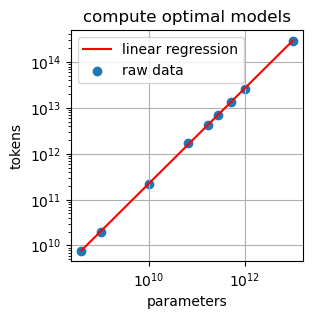

In [39]:
# Create a new figure for the plot with a specified size
plt.figure(figsize=(3, 3))

# Plot the linear regression line
# For each point in 'raw', compute the corresponding y-value using the linear regression equation
plt.plot([q[0] for q in raw], [10**(m*np.log10(q[0]) + c) for q in raw], label='linear regression', color='r')

# Scatter plot of the raw data points
# Each point is represented by its x and y values from the 'raw' list
plt.scatter([q[0] for q in raw], [q[1] for q in raw], label='raw data')

# Set the x-axis and y-axis to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Set the labels for the x-axis and y-axis
plt.xlabel('parameters')
plt.ylabel('tokens')

# Set the title of the plot
plt.title('compute optimal models')

# Display a grid in the plot
plt.grid()

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [40]:
# Define the query model size (e.g., GPT-2 small is 124M)
xquery = 20100000

# Use the linear regression equation to predict the parameters for the given model size
yquery = 10**(m*np.log10(xquery) + c)

# Print the predicted parameters for the specified model size
# The model size is formatted with commas for better readability
print(f"predicted parameters for {xquery:,.2f} tokens: {yquery:,.2f}")

predicted parameters for 20,100,000.00 tokens: 344,908,651.96


## Train the model

In [41]:
# Define hyperparameters for model architecture
# These parameters can be adjusted based on the size of the data and the specific requirements of the task

n_layer = 6 # Number of layers in the transformer model
n_head = 8 # Number of attention heads in each transformer layer
n_emb = 512 # Dimensionality of the embedding layer

In [42]:
# Use Hugging Face's AutoConfig to create a configuration for the GPT-2 model
# The configuration is based on the "gpt2" pre-trained model, and some parameters are customized

# Define the configuration using AutoConfig
config = AutoConfig.from_pretrained(
    "gpt2",                               # Base model: "gpt2"
    vocab_size=len(tokenizer),            # Vocabulary size based on the tokenizer
    n_positions=context_length,           # Maximum position embeddings (context length)
    n_layer=n_layer,                      # Number of transformer layers
    n_head=n_head,                        # Number of attention heads in each layer
    pad_token_id=tokenizer.pad_token_id,  # ID of the padding token
    bos_token_id=tokenizer.bos_token_id,  # ID of the beginning-of-sequence token
    eos_token_id=tokenizer.eos_token_id,  # ID of the end-of-sequence token
    n_embd=n_emb                           # Dimensionality of the embedding layer
)

# Create an instance of the GPT-2 language model using the configured parameters
model = GPT2LMHeadModel(config)


In [43]:
# Calculate and print the size of the GPT-2 model in terms of parameters
# The size is measured in millions (M) of parameters

# Calculate the total number of parameters in the GPT-2 model
model_size = sum(t.numel() for t in model.parameters())

# Print the size of the GPT-2 model in millions of parameters
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 20.1M parameters


Create a datacollator to will take care of preparing the data:

"Before we can start training, we need to set up a data collator that will take care of creating the batches. We can use the DataCollatorForLanguageModeling collator, which is designed specifically for language modeling (as the name subtly suggests). Besides stacking and padding batches, it also takes care of creating the language model labels — in causal language modeling the inputs serve as labels too (just shifted by one element), and this data collator creates them on the fly during training so we don’t need to duplicate the input_ids.

Note that DataCollatorForLanguageModeling supports both masked language modeling (MLM) and causal language modeling (CLM). By default it prepares data for MLM, but we can switch to CLM by setting the argument mlm=False:"

In [44]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [45]:
# Test the data collator on a small subset of the training data
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])

# Print the shapes of the collated outputs
for key in out:
    print(f"{key} shape: {out[key].shape}")

# Display the collated outputs
print(f"Collated outputs: {out}")

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids shape: torch.Size([5, 359])
attention_mask shape: torch.Size([5, 359])
labels shape: torch.Size([5, 359])
Collated outputs: {'input_ids': tensor([[ 74,  24,  22,  ...,   3,   3,   3],
        [ 74,  24,  22,  ...,   3,   3,   3],
        [ 74,  24,  22,  ..., 111,   8,  23],
        [ 74,  24,  22,  ...,   3,   3,   3],
        [ 74,  24,  22,  ...,   3,   3,   3]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[  74,   24,   22,  ..., -100, -100, -100],
        [  74,   24,   22,  ..., -100, -100, -100],
        [  74,   24,   22,  ...,  111,    8,   23],
        [  74,   24,   22,  ..., -100, -100, -100],
        [  74,   24,   22,  ..., -100, -100, -100]])}


In [46]:
# Login into wandb
wandb.login()

wandb: Currently logged in as: naomitunstead (musicgen). Use `wandb login --relogin` to force relogin


True

In [47]:
# Set the WandB environment variable to log the model checkpoint
%env WANDB_LOG_MODEL='checkpoint'

env: WANDB_LOG_MODEL='checkpoint'


In [48]:
# Login into Hugging Face
notebook_login()

In [49]:
# Create the args for out trainer

# Get the output directory with timestamp.
output_path = "output"
steps = 5000

# Define training configuration parameters
# Commented parameters correspond to the small model
config = {"output_dir": output_path,
          "num_train_epochs": 1,
          "per_device_train_batch_size": 8,
          "per_device_eval_batch_size": 4,
          "evaluation_strategy": "steps",
          "save_strategy": "steps",
          "eval_steps": steps,
          "logging_steps":steps,
          "logging_first_step": True,
          "save_total_limit": 5,
          "save_steps": steps,
          "lr_scheduler_type": "cosine",
          "learning_rate":5e-4,
          "warmup_ratio": 0.01,
          "weight_decay": 0.01,
          "seed": 1,
          "load_best_model_at_end": True,
          "report_to": "wandb"}

# Create Namespace object with configuration
args = Namespace(**config)

In [50]:
# Set the random seed for reproducibility
set_seed(args.seed)

In [51]:
# Initialize and start a new WandB run for training
run = wandb.init(project=wandb_project, job_type="training", config=args)

In [52]:
# Code for converting token sequences to NoteSequences with audio-related information

# Constants for note durations
NOTE_LENGTH_16TH_120BPM = 0.25 * 60 / 120
BAR_LENGTH_120BPM = 4.0 * 60 / 120

def token_sequence_to_note_sequence(token_sequence, use_program=True, use_drums=True, instrument_mapper=None, only_piano=False):
    """
    Convert a token sequence to a NoteSequence with audio-related information.
    Args:
        token_sequence (list or str): Token sequence representing musical information.
        use_program (bool): Whether to use program information for instruments.
        use_drums (bool): Whether to include drums in the output.
        instrument_mapper (dict): Mapping of instrument names to MIDI program numbers.
        only_piano (bool): Whether to include only piano instruments in the output.
    Returns:
        note_sequence (NoteSequence): Converted NoteSequence.
    """

    if isinstance(token_sequence, str):
        token_sequence = token_sequence.split()

    note_sequence = empty_note_sequence()

    # Render all notes.
    current_program = 1
    current_is_drum = False
    current_instrument = 0
    track_count = 0
    for token_index, token in enumerate(token_sequence):

        if token == "PIECE_START":
            pass
        elif token == "PIECE_END":
            print("The end.")
            break
        elif token == "TRACK_START":
            current_bar_index = 0
            track_count += 1
            pass
        elif token == "TRACK_END":
            pass
        elif token == "KEYS_START":
            pass
        elif token == "KEYS_END":
            pass
        elif token.startswith("KEY="):
            pass
        elif token.startswith("INST"):
            instrument = token.split("=")[-1]
            if instrument != "DRUMS" and use_program:
                if instrument_mapper is not None:
                    if instrument in instrument_mapper:
                        instrument = instrument_mapper[instrument]
                current_program = int(instrument)
                current_instrument = track_count
                current_is_drum = False
            if instrument == "DRUMS" and use_drums:
                current_instrument = 0
                current_program = 0
                current_is_drum = True
        elif token == "BAR_START":
            current_time = current_bar_index * BAR_LENGTH_120BPM
            current_notes = {}
        elif token == "BAR_END":
            current_bar_index += 1
            pass
        elif token.startswith("NOTE_ON"):
            pitch = int(token.split("=")[-1])
            note = note_sequence.notes.add()
            note.start_time = current_time
            note.end_time = current_time + 4 * NOTE_LENGTH_16TH_120BPM
            note.pitch = pitch
            note.instrument = current_instrument
            note.program = current_program
            note.velocity = 80
            note.is_drum = current_is_drum
            current_notes[pitch] = note
        elif token.startswith("NOTE_OFF"):
            pitch = int(token.split("=")[-1])
            if pitch in current_notes:
                note = current_notes[pitch]
                note.end_time = current_time
        elif token.startswith("TIME_DELTA"):
            delta = float(token.split("=")[-1]) * NOTE_LENGTH_16TH_120BPM
            current_time += delta
        elif token.startswith("DENSITY="):
            pass
        elif token == "[PAD]":
            pass
        else:
            #print(f"Ignored token {token}.")
            pass

    # Make the instruments right.
    instruments_drums = []
    for note in note_sequence.notes:
        pair = [note.program, note.is_drum]
        if pair not in instruments_drums:
            instruments_drums += [pair]
        note.instrument = instruments_drums.index(pair)

    if only_piano:
        for note in note_sequence.notes:
            if not note.is_drum:
                note.instrument = 0
                note.program = 0

    return note_sequence

def empty_note_sequence(qpm=120.0, total_time=0.0):
    """
    Create an empty NoteSequence with specified tempo and total time.
    Args:
        qpm (float): Quarter notes per minute (tempo).
        total_time (float): Total time of the NoteSequence.
    Returns:
        note_sequence (NoteSequence): Empty NoteSequence.
    """
    note_sequence = note_seq.protobuf.music_pb2.NoteSequence()
    note_sequence.tempos.add().qpm = qpm
    note_sequence.ticks_per_quarter = note_seq.constants.STANDARD_PPQ
    note_sequence.total_time = total_time
    return note_sequence

In [53]:
# first create a custom trainer to log prediction distribution
SAMPLE_RATE=44100
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def evaluation_loop(
        self,
        dataloader,
        description,
        prediction_loss_only=None,
        ignore_keys=None,
        metric_key_prefix="eval",
    ):
        """
        Custom evaluation loop to log prediction distribution.
        Args:
            dataloader: DataLoader for evaluation data.
            description: Description of the evaluation.
            prediction_loss_only: If True, only calculate prediction loss.
            ignore_keys: List of keys to ignore.
            metric_key_prefix: Prefix for metric keys.
        Returns:
            eval_output: Evaluation output.
        """
        # Call super class method to get the eval outputs
        eval_output = super().evaluation_loop(
            dataloader,
            description,
            prediction_loss_only,
            ignore_keys,
            metric_key_prefix,
        )

        # Log the prediction distribution using `wandb.Histogram` method.
        if wandb.run is not None:
            input_ids = tokenizer.encode("PIECE_START STYLE=JSFAKES GENRE=JSFAKES TRACK_START", return_tensors="pt").cuda()
            # Generate more tokens.
            voice1_generated_ids = model.generate(
                input_ids,
                max_length=512,
                do_sample=True,
                temperature=0.75,
                eos_token_id=tokenizer.encode("TRACK_END")[0]
            )
            voice2_generated_ids = model.generate(
                voice1_generated_ids,
                max_length=512,
                do_sample=True,
                temperature=0.75,
                eos_token_id=tokenizer.encode("TRACK_END")[0]
            )
            voice3_generated_ids = model.generate(
                voice2_generated_ids,
                max_length=512,
                do_sample=True,
                temperature=0.75,
                eos_token_id=tokenizer.encode("TRACK_END")[0]
            )
            voice4_generated_ids = model.generate(
                voice3_generated_ids,
                max_length=512,
                do_sample=True,
                temperature=0.75,
                eos_token_id=tokenizer.encode("TRACK_END")[0]
            )
            token_sequence = tokenizer.decode(voice4_generated_ids[0])
            note_sequence = token_sequence_to_note_sequence(token_sequence)
            synth = note_seq.fluidsynth
            array_of_floats = synth(note_sequence, sample_rate=SAMPLE_RATE)
            int16_data = note_seq.audio_io.float_samples_to_int16(array_of_floats)
            wandb.log({"Generated_audio": wandb.Audio(int16_data, SAMPLE_RATE)})


        return eval_output

In [54]:
# Create TrainingArguments object with training configuration 
train_args = TrainingArguments(**config)

In [55]:
# Create a CustomTrainer instance for model training

# Initialize a CustomTrainer with the specified parameters
trainer = CustomTrainer(
    model=model,
    tokenizer=tokenizer,
    args=train_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

In [56]:
# Train the model.
trainer.train()

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# call wandb.finish() to finish the run
wandb.finish()